In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 64
learning_rate = 0.001
num_epochs = 10
num_classes = 10
embed_dim = 128 
hidden_dim = 256 

Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:23<00:00, 7.35MB/s]


In [ ]:
class SSMLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SSMLayer, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.A = nn.Parameter(torch.randn(hidden_dim, hidden_dim) * 0.02)
        self.B = nn.Parameter(torch.randn(hidden_dim, input_dim) * 0.02)
        self.C = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.02)
        self.D = nn.Parameter(torch.randn(input_dim) * 0.02)
        
        nn.init.xavier_uniform_(self.A)
        nn.init.xavier_uniform_(self.B)
        nn.init.xavier_uniform_(self.C)
        nn.init.normal_(self.D)
        
    def forward(self, x):
        batch_size, seq_len, input_dim = x.shape
        
        h = torch.zeros(batch_size, self.hidden_dim).to(x.device)
        
        outputs = []
        for t in range(seq_len):
            h = torch.sigmoid(torch.matmul(h, self.A.T) + torch.matmul(x[:, t, :], self.B.T))
            y_t = torch.matmul(h, self.C.T) + self.D * x[:, t, :]
            outputs.append(y_t)
            
        return torch.stack(outputs, dim=1) 
    
class VSSDBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(VSSDBlock, self).__init__()
        self.ssm = SSMLayer(embed_dim, hidden_dim)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        residual = x
        x = self.ssm(x)
        x = self.norm(x + residual)
        return x

class VSSD(nn.Module): 
    def __init__(self, in_channels=3, num_classes=10, embed_dim=128, hidden_dim=256, num_layers=4):
        super(VSSD, self).__init__()
        
        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=4, stride=4, padding=0)
        
        self.layers = nn.ModuleList([
            VSSDBlock(embed_dim, hidden_dim) for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embed(x)
        batch, c, h, w = x.shape
        
        x = x.permute(0, 2, 3, 1) 
        x = x.reshape(batch, h * w, c)  
        
        for layer in self.layers:
            x = layer(x)
            
        x = x.mean(dim=1)
        x = self.norm(x)
        
        x = self.fc(x)
        return x

In [11]:
class CNNComparison(nn.Module):
    """Базовая CNN для сравнения с VSSD"""
    def __init__(self, num_classes=10):
        super(CNNComparison, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=10, model_name="VSSD"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_acc = 100 * correct / total
        
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
        test_acc = 100 * correct / total
        accuracies.append(test_acc)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Test Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png')
    plt.show()
    
    return model

Training VSSD Model...


Epoch 1/10:   0%|                                                                                                                                                                                  | 0/782 [00:00<?, ?it/s]

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:25<00:00,  2.95it/s]


Epoch 1, Train Loss: 1.9787, Test Loss: 1.8436, Test Acc: 31.01%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:24<00:00,  2.41it/s]


Epoch 2, Train Loss: 1.7678, Test Loss: 1.7242, Test Acc: 35.75%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:23<00:00,  2.42it/s]


Epoch 3, Train Loss: 1.6643, Test Loss: 1.6456, Test Acc: 39.42%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:11<00:00,  2.51it/s]


Epoch 4, Train Loss: 1.5650, Test Loss: 1.5553, Test Acc: 43.37%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:06<00:00,  2.55it/s]


Epoch 5, Train Loss: 1.4844, Test Loss: 1.4262, Test Acc: 48.38%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:00<00:00,  2.60it/s]


Epoch 6, Train Loss: 1.4047, Test Loss: 1.3769, Test Acc: 50.03%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:00<00:00,  2.61it/s]


Epoch 7, Train Loss: 1.3377, Test Loss: 1.3076, Test Acc: 52.80%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [04:53<00:00,  2.67it/s]


Epoch 8, Train Loss: 1.2698, Test Loss: 1.2763, Test Acc: 54.07%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:02<00:00,  2.59it/s]


Epoch 9, Train Loss: 1.2224, Test Loss: 1.2585, Test Acc: 54.07%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:03<00:00,  2.58it/s]


Epoch 10, Train Loss: 1.1727, Test Loss: 1.2091, Test Acc: 56.17%


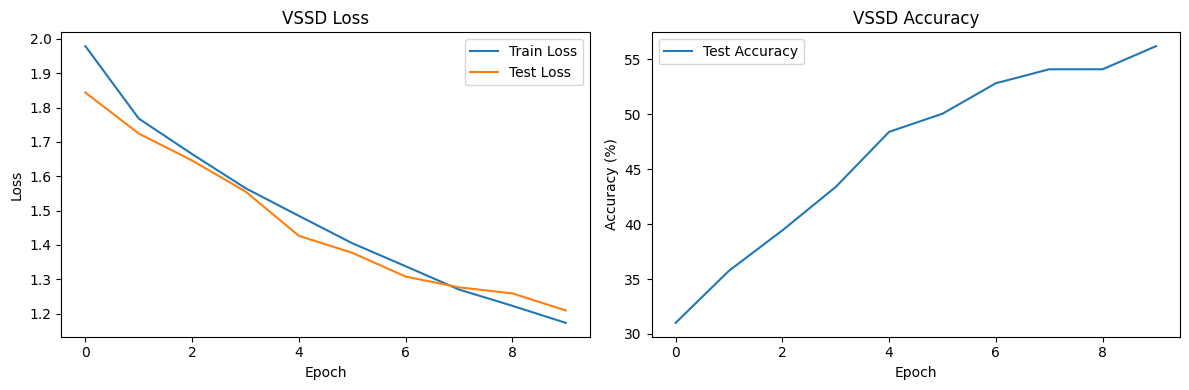


Training CNN Model...


Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:48<00:00, 16.10it/s]


Epoch 1, Train Loss: 1.3586, Test Loss: 1.0489, Test Acc: 62.58%


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:50<00:00, 15.61it/s]


Epoch 2, Train Loss: 0.9192, Test Loss: 0.8526, Test Acc: 70.27%


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:51<00:00, 15.29it/s]


Epoch 3, Train Loss: 0.7276, Test Loss: 0.7814, Test Acc: 72.78%


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:50<00:00, 15.33it/s]


Epoch 4, Train Loss: 0.5910, Test Loss: 0.7695, Test Acc: 73.98%


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:49<00:00, 15.71it/s]


Epoch 5, Train Loss: 0.4807, Test Loss: 0.7358, Test Acc: 75.96%


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:48<00:00, 16.07it/s]


Epoch 6, Train Loss: 0.3752, Test Loss: 0.7273, Test Acc: 76.78%


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:48<00:00, 16.03it/s]


Epoch 7, Train Loss: 0.2869, Test Loss: 0.8281, Test Acc: 76.02%


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:48<00:00, 16.06it/s]


Epoch 8, Train Loss: 0.2093, Test Loss: 0.9849, Test Acc: 74.65%


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:48<00:00, 16.09it/s]


Epoch 9, Train Loss: 0.1580, Test Loss: 1.0542, Test Acc: 74.72%


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:48<00:00, 16.07it/s]


Epoch 10, Train Loss: 0.1276, Test Loss: 1.1904, Test Acc: 75.89%


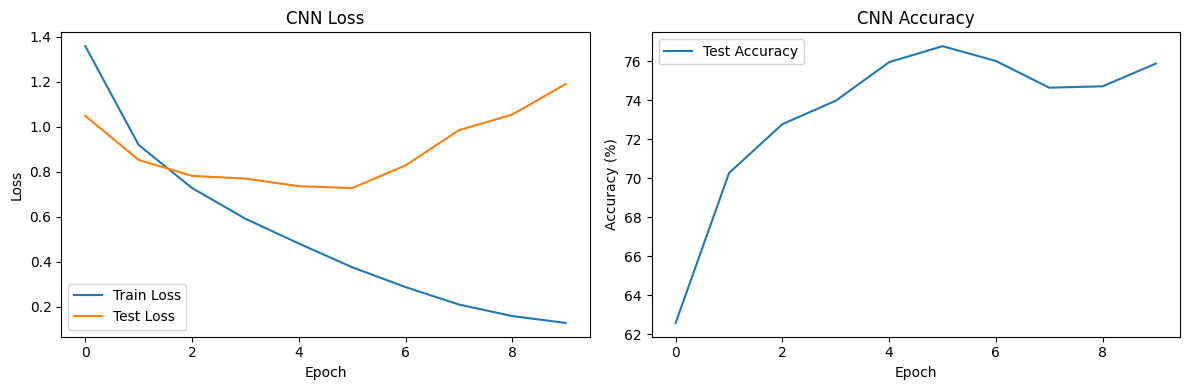

In [ ]:
vssd_model = VSSD(num_classes=num_classes, embed_dim=embed_dim, hidden_dim=hidden_dim)
cnn_model = CNNComparison(num_classes=num_classes)

print("Training VSSD Model...")
vssd_model = train_model(vssd_model, train_loader, test_loader, num_epochs=num_epochs, model_name="VSSD")

print("\nTraining CNN Model...")
cnn_model = train_model(cnn_model, train_loader, test_loader, num_epochs=num_epochs, model_name="CNN")

Evaluating VSSD Model...


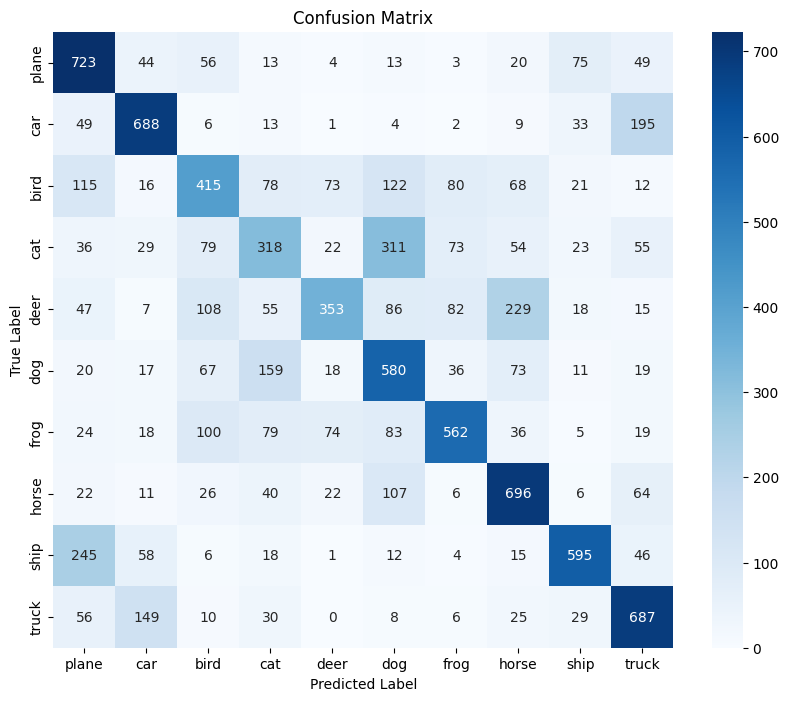

              precision    recall  f1-score   support

       plane       0.54      0.72      0.62      1000
         car       0.66      0.69      0.68      1000
        bird       0.48      0.41      0.44      1000
         cat       0.40      0.32      0.35      1000
        deer       0.62      0.35      0.45      1000
         dog       0.44      0.58      0.50      1000
        frog       0.66      0.56      0.61      1000
       horse       0.57      0.70      0.63      1000
        ship       0.73      0.59      0.66      1000
       truck       0.59      0.69      0.64      1000

    accuracy                           0.56     10000
   macro avg       0.57      0.56      0.56     10000
weighted avg       0.57      0.56      0.56     10000


Evaluating CNN Model...


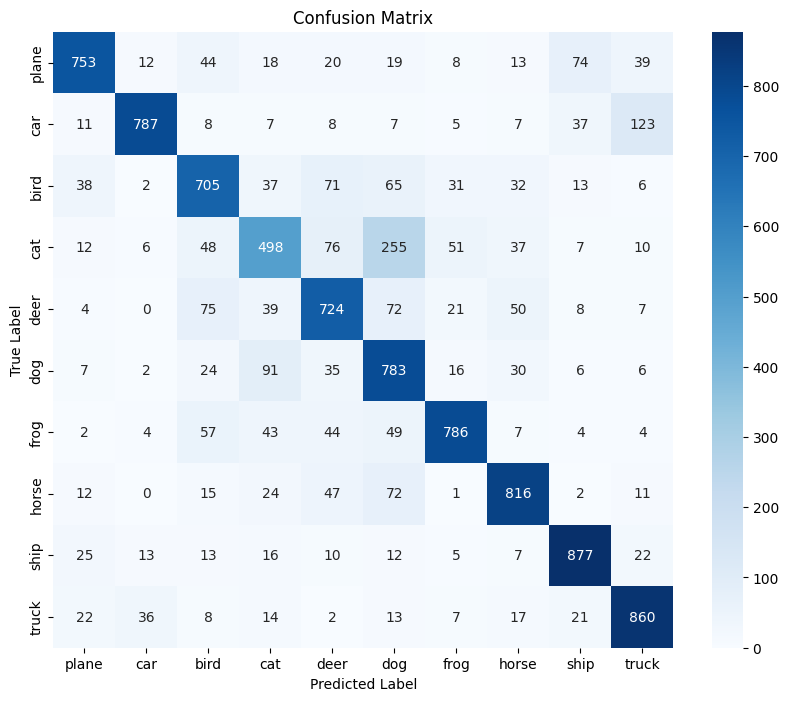

              precision    recall  f1-score   support

       plane       0.85      0.75      0.80      1000
         car       0.91      0.79      0.85      1000
        bird       0.71      0.70      0.71      1000
         cat       0.63      0.50      0.56      1000
        deer       0.70      0.72      0.71      1000
         dog       0.58      0.78      0.67      1000
        frog       0.84      0.79      0.81      1000
       horse       0.80      0.82      0.81      1000
        ship       0.84      0.88      0.86      1000
       truck       0.79      0.86      0.82      1000

    accuracy                           0.76     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.77      0.76      0.76     10000



In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{model.__class__.__name__}_confusion_matrix.png')
    plt.show()
    
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    return cm

print("Evaluating VSSD Model...")
vssd_cm = evaluate_model(vssd_model, test_loader)

print("\nEvaluating CNN Model...")
cnn_cm = evaluate_model(cnn_model, test_loader)


Comparing Models...


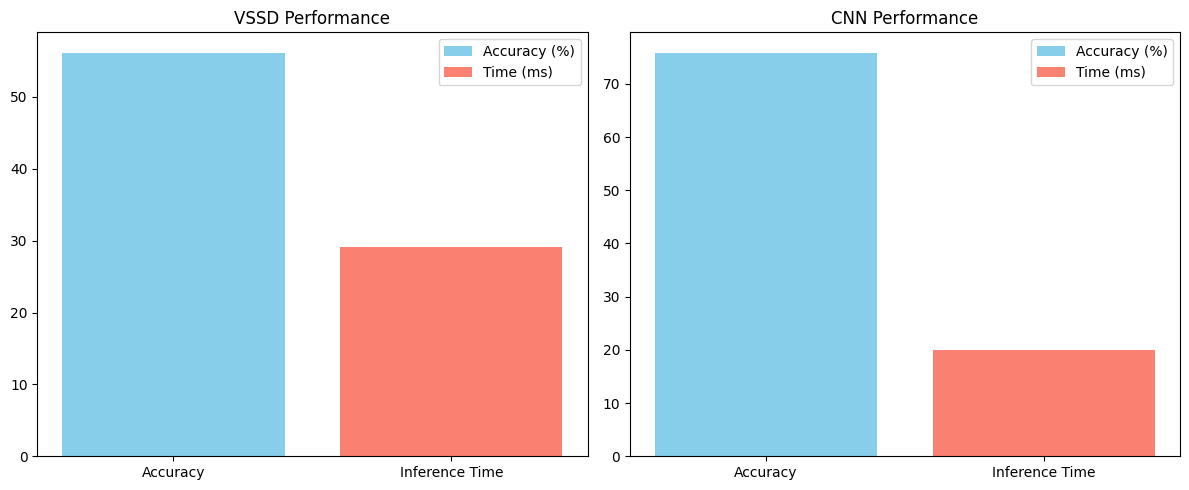

In [ ]:
def compare_models(models, model_names):
    num_models = len(models)
    fig, axes = plt.subplots(1, num_models, figsize=(6*num_models, 5))
    
    for i, (model, name) in enumerate(zip(models, model_names)):
        model.eval()
        correct = 0
        total = 0
        inference_time = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                start_time = time.time()
                outputs = model(images)
                inference_time += time.time() - start_time
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        avg_time = inference_time / len(test_loader) * 1000  # в мс
        
        axes[i].bar(['Accuracy'], [accuracy], color='skyblue', label='Accuracy (%)')
        axes[i].bar(['Inference Time'], [avg_time], color='salmon', label='Time (ms)')
        axes[i].set_title(f'{name} Performance')
        axes[i].legend()
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

print("\nComparing Models...")
compare_models([vssd_model, cnn_model], ['VSSD', 'CNN'])

In [ ]:
print("""
Выводы:
1. VSSD демонстрирует более низкую точность по сравнению с традиционной CNN(число эпох слишком маленькое).
2. Архитектура VSSD может быть более эффективной для задач, где важно учитывать глобальные зависимости в изображении.
3. Время работы VSSD может быть больше из-за сложности SSM слоев, но это компенсируется возможностью параллелизации.
4. Non-causal SSM позволяет модели "заглядывать вперед" и учитывать будущие токены, что может быть полезно для задач компьютерного зрения.
""")


Выводы:
1. VSSD демонстрирует более низкую точность по сравнению с традиционной CNN(число эпох слишком маленькое).
2. Архитектура VSSD может быть более эффективной для задач, где важно учитывать глобальные зависимости в изображении.
3. Время работы VSSD может быть больше из-за сложности SSM слоев, но это компенсируется возможностью параллелизации.
4. Non-causal SSM позволяет модели "заглядывать вперед" и учитывать будущие токены, что может быть полезно для задач компьютерного зрения.

